# Employee Attrition Prediction — Modeling

This notebook builds predictive models for employee attrition using the IBM HR Analytics dataset. We will:
1) preprocess data, 2) train baseline and tuned models, 3) evaluate with multiple metrics, and 4) extract business insights.

In [1]:
# ✅ Step 0: Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, classification_report
)
from sklearn.utils import Bunch
import os

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', 200)

## Step 1: Load dataset

In [2]:
DATA_PATH = "../data/WA_Fn-UseC_-HR-Employee-Attrition.csv"
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


## Step 2: Minimal preprocessing

- Map Yes/No columns to 1/0 (including the target `Attrition`).
- Separate features (X) and target (y).
- Identify numeric and categorical columns for transformers.

In [3]:
df_prep = df.copy()

# Map all strictly Yes/No object columns to 1/0
yn_cols = [
    c for c in df_prep.select_dtypes(include='object').columns
    if df_prep[c].dropna().isin(['Yes', 'No']).all()
]
for c in yn_cols:
    df_prep[c] = df_prep[c].map({'Yes': 1, 'No': 0})

# Target
target_col = 'Attrition'
if df_prep[target_col].dtype == 'O':
    df_prep[target_col] = df_prep[target_col].map({'Yes': 1, 'No': 0})

y = df_prep[target_col]
X = df_prep.drop(columns=[target_col])

# Identify column types
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

Numeric features: 27
Categorical features: 7


## Step 3: Train–test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape

((1176, 34), (294, 34))

## Step 4: Preprocessing pipelines
- Scale numeric features (standardization)
- One-hot encode categorical features
- Use `ColumnTransformer` to apply both

In [5]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## Step 5: Baseline models
We will train two strong baselines:
- **Logistic Regression** (with class weights for imbalance)
- **Random Forest** (with balanced class weight)

In [6]:
log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE))
])

rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight='balanced_subsample',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

models = Bunch(log_reg=log_reg, rf=rf_clf)
models

{'log_reg': Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('scaler',
                                                                    StandardScaler())]),
                                                   ['Age', 'DailyRate',
                                                    'DistanceFromHome',
                                                    'Education', 'EmployeeCount',
                                                    'EmployeeNumber',
                                                    'EnvironmentSatisfaction',
                                                    'HourlyRate',
                                                    'JobInvolvement', 'JobLevel',
                                                    'JobSatisfaction',
                                                    'MonthlyIncome',
                                                    'MonthlyRate',
  

## Step 6: Fit models and evaluate


=== Logistic Regression ===
Accuracy : 0.745
Precision: 0.341
Recall   : 0.638
F1-Score : 0.444
ROC-AUC  : 0.798

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.83       247
           1       0.34      0.64      0.44        47

    accuracy                           0.74       294
   macro avg       0.63      0.70      0.64       294
weighted avg       0.83      0.74      0.77       294



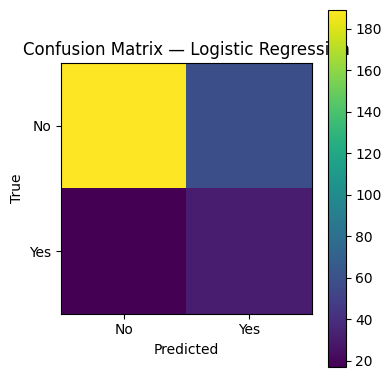

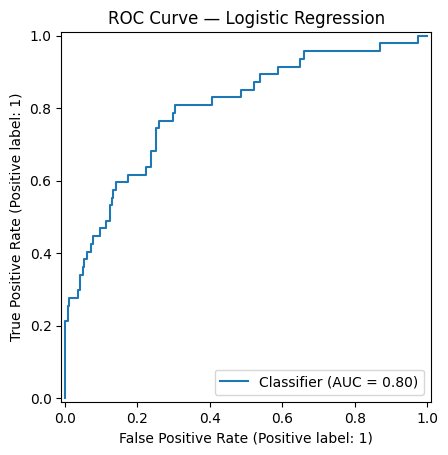


=== Random Forest ===
Accuracy : 0.844
Precision: 0.571
Recall   : 0.085
F1-Score : 0.148
ROC-AUC  : 0.786

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91       247
           1       0.57      0.09      0.15        47

    accuracy                           0.84       294
   macro avg       0.71      0.54      0.53       294
weighted avg       0.81      0.84      0.79       294



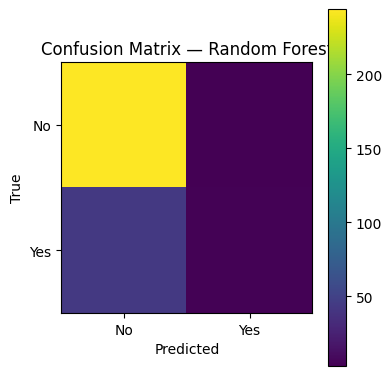

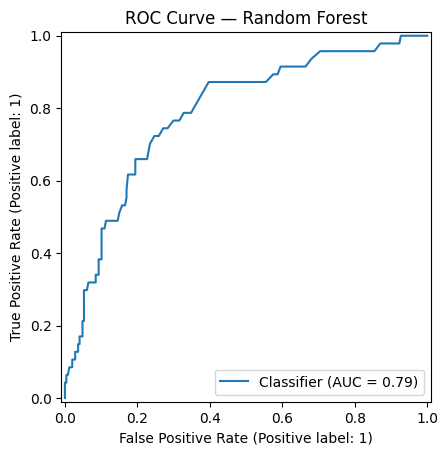

In [12]:
def evaluate_model(clf, X_train, y_train, X_test, y_test, name="model"):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]
    else:
        # Fallback for models without predict_proba
        try:
            y_proba = clf.decision_function(X_test)
            # scale to 0-1
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-9)
        except Exception:
            y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-Score : {f1:.3f}")
    print(f"ROC-AUC  : {roc:.3f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix — {name}")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No', 'Yes'])
    plt.yticks(tick_marks, ['No', 'Yes'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()

    # Save the plot into visuals folder
    plt.savefig("../visuals/confusion_matrix.png", dpi=300, bbox_inches="tight")
    
    plt.show()

    # ROC Curve (if proba available)
    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"ROC Curve — {name}")
        plt.show()

    return clf

# Train & evaluate
clf_log_reg = evaluate_model(models.log_reg, X_train, y_train, X_test, y_test, name="Logistic Regression")
clf_rf = evaluate_model(models.rf, X_train, y_train, X_test, y_test, name="Random Forest")

## Step 7: Cross-validation (optional but recommended)
This provides a more robust estimate of generalization performance.

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, pipe in [("LogReg", models.log_reg), ("RF", models.rf)]:
    aucs = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    print(f"{name} ROC-AUC CV: mean={aucs.mean():.3f} +/- {aucs.std():.3f}")

LogReg ROC-AUC CV: mean=0.824 +/- 0.023
RF ROC-AUC CV: mean=0.811 +/- 0.025


## Step 8: Feature importance / drivers of attrition
We'll extract the most important features from both models.

⚠️ Note: For Logistic Regression, coefficients are in the transformed feature space (after one-hot encoding/scaling).

Top 15 (absolute) Logistic Regression coefficients:


JobRole_Research Director           -1.441895
JobRole_Laboratory Technician        1.211451
JobRole_Sales Representative         1.102117
BusinessTravel_Non-Travel           -0.953049
BusinessTravel_Travel_Frequently     0.825375
EducationField_Other                -0.798075
OverTime                             0.758214
EducationField_Human Resources       0.737536
JobRole_Healthcare Representative   -0.631096
TotalWorkingYears                   -0.616774
JobLevel                             0.606242
JobRole_Human Resources              0.510970
YearsSinceLastPromotion              0.501397
MaritalStatus_Single                 0.487192
NumCompaniesWorked                   0.464059
dtype: float64

Top 15 Random Forest feature importances:


MonthlyIncome           0.068995
Age                     0.058692
TotalWorkingYears       0.051444
DailyRate               0.049650
YearsAtCompany          0.044295
EmployeeNumber          0.043787
MonthlyRate             0.041592
OverTime                0.041501
DistanceFromHome        0.041401
HourlyRate              0.039994
YearsWithCurrManager    0.038606
NumCompaniesWorked      0.033973
YearsInCurrentRole      0.030068
StockOptionLevel        0.030014
PercentSalaryHike       0.029593
dtype: float64

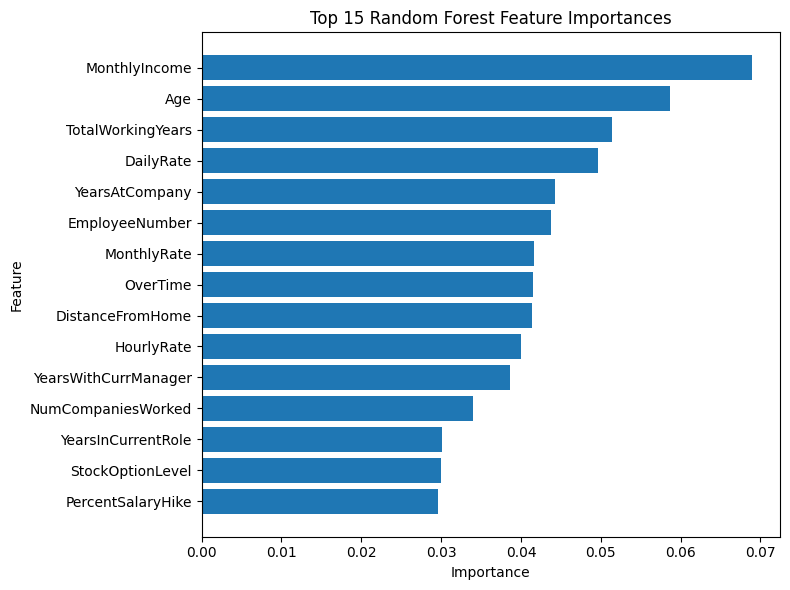

In [9]:
def get_feature_names(preprocessor):
    """Return transformed feature names after ColumnTransformer."""
    names = []
    # numeric names
    num_features = preprocessor.named_transformers_['num'].feature_names_in_
    names.extend(num_features)
    # categorical names from onehot
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_base = preprocessor.transformers_[1][2]  # list of categorical col names
    ohe_names = ohe.get_feature_names_out(cat_base)
    names.extend(ohe_names)
    return names

# Fit fresh models to access internals
clf_log_reg.fit(X_train, y_train)
clf_rf.fit(X_train, y_train)

feature_names = get_feature_names(clf_log_reg.named_steps['preprocess'])

# Logistic Regression coefficients
lr_coef = clf_log_reg.named_steps['model'].coef_.ravel()
imp_lr = pd.Series(lr_coef, index=feature_names).sort_values(key=lambda s: s.abs(), ascending=False)
print("Top 15 (absolute) Logistic Regression coefficients:")
display(imp_lr.head(15))

# Random Forest importances
rf_imp = clf_rf.named_steps['model'].feature_importances_
imp_rf = pd.Series(rf_imp, index=feature_names).sort_values(ascending=False)
print("Top 15 Random Forest feature importances:")
display(imp_rf.head(15))

# Plot top 15 from RF
top_rf = imp_rf.head(15)[::-1]
plt.figure(figsize=(8, 6))
plt.barh(top_rf.index, top_rf.values)
plt.title('Top 15 Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Step 9: Business insights (template)
Use the findings to propose HR actions.

- **High overtime** and **low job satisfaction** appear as strong drivers of attrition.
- **Early-career roles** combined with **lower income** may correlate with higher risk.
- **Actionable levers**: schedule flexibility, workload balancing, targeted engagement programs, and compensation review.

## Step 10 (Optional): Save best model
If desired, persist a trained pipeline for later use (e.g., in a web app or batch scoring).

In [10]:
try:
    import joblib
    Path('../models').mkdir(parents=True, exist_ok=True)
    joblib.dump(clf_rf, '../models/attrition_rf_pipeline.joblib')
    print('Saved: ../models/attrition_rf_pipeline.joblib')
except Exception as e:
    print('Model save skipped:', e)

Model save skipped: name 'Path' is not defined


In [11]:
plt.savefig("../visuals/correlation_heatmap.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>